In [109]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from pandas import read_csv
from sklearn.model_selection import train_test_split

import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [114]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

In [3]:
def prepare_data(df, num_elements=50):
    new_data = []
    length = df.shape[0]
    current_index = 0
    step = int(0.2 * num_elements)
    while(current_index <= length - num_elements):
        new_data.append(df[current_index:current_index+num_elements])
        current_index += step
    return new_data

In [4]:
class BPNN(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(BPNN, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(input_size, hidden_size)  
        self.fc2 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
def prepare_data(df, num_elements=50):
    new_data = []
    length = df.shape[0]
    current_index = 0
    step = int(0.2 * num_elements)
    while(current_index <= length - num_elements):
        new_data.append(df[current_index:current_index+num_elements])
        current_index += step
    return new_data

In [6]:
def learn(num, count, data_len, lr=0.01):
    num = [str(i) for i in range(num)]
    p1 = [read_csv('ics_data_preprocessed/07_Smart_Meter_65/P1/' + str(count) + '/' + n + '.csv', squeeze=True, parse_dates=['ts'], index_col='ts') for n in num]
    
    p1 = [prepare_data(df, data_len) for df in p1]
    p1 = sum(p1, [])
    p1 = [df.values.tolist() for df in p1]
    
    train, test = train_test_split(p1, test_size=0.2, random_state=42)
    train_data_normalized = train
    test_data_normalized = test
    
    train_data, val_data = train_test_split(train_data_normalized, test_size=0.15, random_state=42)
    train_data = torch.FloatTensor(train_data)
    val_data = torch.FloatTensor(val_data)
    test_data = torch.FloatTensor(test_data_normalized)
    
    X_train = train_data[:, :-10]
    y_train = train_data[:, -10:]
    X_val = val_data[:, :-10]
    y_val = val_data[:, -10:]
    X_test = test_data[:, :-10]
    y_test = test_data[:, -10:]
    
    print("Data is ready")
    
    best_model = BPNN(40, 50)
    loss_function = nn.MSELoss()
    
    val_losses = []
    
    best_hidden_layer_size = 50
    
    for hidden_layer_size in [50, 100, 200, 250, 300]:
        losses = []
        
    
        model = BPNN(data_len - 10, hidden_layer_size)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
        epochs = 1000
        
        for i in range(epochs):
            model.train()
            
            optimizer.zero_grad()
            
            y_pred = model(X_train)
            single_loss = loss_function(y_pred, y_train)
            losses.append(single_loss)
            
            single_loss.backward()
            optimizer.step()
            
            
            model.eval()

            with torch.no_grad():
                y_pred = model(X_val)

                single_loss = loss_function(y_pred, y_val)

                if (len(val_losses) == 0) or (single_loss < min(val_losses)):
#                     if (len(val_losses) > 0):
#                         print("losses:", single_loss, min(val_losses))
                    best_hidden_layer_size = hidden_layer_size
                    best_model = model
                
                val_losses.append(single_loss)
            
#             if (len(val_losses) > 0 and i%5 == 1):
#                 print(val_losses[-1], min(val_losses))

#         print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    
    print("best model hidden size:", best_hidden_layer_size)
    
    predictions = []
    best_model.eval()
    with torch.no_grad():
        predictions = [best_model(seq) for (seq, labels) in zip(X_test, y_test)]
    pred = [torch.cat((i, j)) for (i, j) in zip(X_test, predictions)]
    actual_predictions = np.array([np.array(i) for i in pred])
    mape = [np.mean(np.abs(actual_predictions[i] - test[i])/np.abs(test[i])) for i in range(len(test))]
    print(sum(mape) / len(mape))
    rmse = [np.mean((actual_predictions[i] - test[i])**2)**.5 for i in range(len(test))]
    print(sum(rmse) / len(rmse))
    
    return best_model
     

In [7]:
random.seed(42)

# 1s

In [9]:
new_model = learn(135, 1000, 50)

Data is ready
best model hidden size: 300
0.0028163122105812318
0.9505610617221723


In [10]:
new_model = learn(135, 1000, 100)

Data is ready
best model hidden size: 300
0.0012277763835428913
0.5038227306497034


In [11]:
new_model = learn(135, 1000, 150)

Data is ready
best model hidden size: 200
0.0005861823384180381
0.3207910693706353


In [12]:
new_model = learn(135, 1000, 200)

Data is ready
best model hidden size: 200
0.0010810708238757718
0.21294668597163313


In [13]:
new_model = learn(135, 1000, 250)

Data is ready
best model hidden size: 100
0.00043404644705177244
0.3628611237343954


In [14]:
new_model = learn(135, 1000, 300)

Data is ready
best model hidden size: 50
0.0004839618788334011
0.43524674803656715


In [15]:
new_model = learn(135, 1000, 350)

Data is ready
best model hidden size: 50
0.0006071683493402637
0.18019366119835858


In [16]:
new_model = learn(135, 1000, 400)

Data is ready
best model hidden size: 50
0.0007185971064873042
0.9518536905088414


In [17]:
new_model = learn(135, 1000, 450)

Data is ready
best model hidden size: 100
0.00025391550494295443
0.13397284552833227


In [18]:
new_model = learn(135, 1000, 500)

Data is ready
best model hidden size: 200
0.013423665346033389
9.734407148881857


In [19]:
new_model = learn(135, 1000, 550)

Data is ready
best model hidden size: 50
0.0002186655102927107
0.1361223213709008


In [20]:
new_model = learn(135, 1000, 600)

Data is ready
best model hidden size: 50
0.0005131486625889432
0.582398940092793


In [21]:
new_model = learn(135, 1000, 650)

Data is ready
best model hidden size: 50
0.00022455131786216077
0.08348968197608626


In [22]:
new_model = learn(135, 1000, 700)

Data is ready
best model hidden size: 50
0.00011109514552105441
0.09145640061658591


In [97]:
new_model = learn(135, 1000, 750)

Data is ready
best model hidden size: 50
0.000806534667894952
0.26054335875508283


In [98]:
new_model = learn(135, 1000, 800)

Data is ready
best model hidden size: 100
0.00011039338701541096
0.32899591709242126


In [99]:
new_model = learn(135, 1000, 850)

Data is ready
best model hidden size: 100
0.006664149991532138
1.3426658148301587


In [100]:
new_model = learn(135, 1000, 900)

Data is ready
best model hidden size: 50
0.0068117778185604605
4.001771837246573


In [101]:
new_model = learn(135, 1000, 950)

Data is ready
best model hidden size: 50
0.0008171749973968957
0.17657782679527312


In [102]:
new_model = learn(135, 1000, 1000)

Data is ready
best model hidden size: 50
0.00653447754020217
2.3454210545874323


# 1.5s

In [23]:
new_model = learn(1145, 1500, 50)

Data is ready
best model hidden size: 100
0.005276510449680501
5.624813416261149


In [24]:
new_model = learn(1145, 1500, 100)

Data is ready
best model hidden size: 250
0.00226868783435594
3.374605674506945


In [25]:
new_model = learn(1145, 1500, 150)

Data is ready
best model hidden size: 250
0.001010753446097395
1.5854321796858968


In [26]:
new_model = learn(1145, 1500, 200)

Data is ready
best model hidden size: 200
0.0013455996819271728
2.4151516373543527


In [27]:
new_model = learn(1145, 1500, 250)

Data is ready
best model hidden size: 100
0.00031643355174274234
0.8446728526417874


In [28]:
new_model = learn(1145, 1500, 300)

Data is ready
best model hidden size: 50
0.00036638701623386123
0.7482640913652224


In [29]:
new_model = learn(1145, 1500, 350)

Data is ready
best model hidden size: 100
0.0009812841544701723
3.506373739892614


In [30]:
new_model = learn(1145, 1500, 400)

Data is ready
best model hidden size: 50
0.0002399103730398868
0.7358127884861662


In [31]:
new_model = learn(1145, 1500, 450)

Data is ready
best model hidden size: 50
0.00023990128150387353
0.39257176546673583


In [32]:
new_model = learn(1145, 1500, 500)

Data is ready
best model hidden size: 50
0.0003681937327340997
0.7813729745298424


In [111]:
new_model = learn(1145, 1500, 550)

Data is ready
best model hidden size: 50
0.0002706857189151699
1.3421542281544194


In [34]:
new_model = learn(1145, 1500, 600)

Data is ready
best model hidden size: 50
0.0006857148774736234
1.8299285686596192


In [35]:
new_model = learn(1145, 1500, 650)

Data is ready
best model hidden size: 100
0.0024031273588366346
4.023633354728794


In [36]:
new_model = learn(1145, 1500, 700)

Data is ready
best model hidden size: 50
0.0018304884263512838
3.7962783870117467


In [103]:
new_model = learn(1145, 1500, 750)

Data is ready
best model hidden size: 50
0.0008303408280127442
1.3108869263571004


In [104]:
new_model = learn(1145, 1500, 800)

Data is ready
best model hidden size: 50
0.01176293526192787
24.138087761812645


In [105]:
new_model = learn(1145, 1500, 850)

Data is ready
best model hidden size: 50
0.0001414520115553943
0.23672395055842851


In [106]:
new_model = learn(1145, 1500, 900)

Data is ready
best model hidden size: 50
0.0004992741742672671
0.7959198810148803


In [107]:
new_model = learn(1145, 1500, 950)

Data is ready
best model hidden size: 100
0.010195270237736732
44.04271131458351


In [122]:
new_model = learn(1145, 1500, 1000)

Data is ready
best model hidden size: 100
0.0097781503902918
47.752345287091714


# 2s

In [37]:
new_model = learn(2410, 2000, 50)

Data is ready
best model hidden size: 300
0.005913975891546345
2.54685202572777


In [38]:
new_model = learn(2410, 2000, 100)

Data is ready
best model hidden size: 100
0.002084978986248612
1.993582722355503


In [39]:
new_model = learn(2410, 2000, 150)

Data is ready
best model hidden size: 50
0.0012177820847496263
1.5313438723358241


In [40]:
new_model = learn(2410, 2000, 200)

Data is ready
best model hidden size: 100
0.0008169222455387245
1.394718796525472


In [41]:
new_model = learn(2410, 2000, 250)

Data is ready
best model hidden size: 100
0.0006932490009962032
1.342387348276914


In [42]:
new_model = learn(2410, 2000, 300)

Data is ready
best model hidden size: 50
0.0005885317921817636
1.5064184896694233


In [43]:
new_model = learn(2410, 2000, 350)

Data is ready
best model hidden size: 50
0.0005246325189148152
1.1357003297715913


In [44]:
new_model = learn(2410, 2000, 400)

Data is ready
best model hidden size: 100
0.0004116997610194775
1.30829463675287


In [45]:
new_model = learn(2410, 2000, 450)

Data is ready
best model hidden size: 250
0.0007066830622950077
2.7379432712882976


In [46]:
new_model = learn(2410, 2000, 500)

Data is ready
best model hidden size: 100
0.0002444375089146401
1.1028512800570467


In [47]:
new_model = learn(2410, 2000, 550)

Data is ready
best model hidden size: 50
0.0005720503037021894
2.044552339394338


In [48]:
new_model = learn(2410, 2000, 600)

Data is ready
best model hidden size: 100
0.0002541245569540078
0.9975103228305309


In [49]:
new_model = learn(2410, 2000, 650)

Data is ready
best model hidden size: 50
0.00027688632882487597
1.1258248428129267


In [50]:
new_model = learn(2410, 2000, 700)

Data is ready
best model hidden size: 50
0.012871531838494587
58.514424026694684


In [51]:
new_model = learn(2410, 2000, 750)

Data is ready
best model hidden size: 100
0.012118458128888808
56.81747316735948


In [52]:
new_model = learn(2410, 2000, 800)

Data is ready
best model hidden size: 50
0.0003443633704141602
1.5463404495866226


In [53]:
new_model = learn(2410, 2000, 850)

Data is ready
best model hidden size: 50
0.0042190631280854115
18.96039830835163


In [54]:
new_model = learn(2410, 2000, 900)

Data is ready
best model hidden size: 50
0.010331614505563825
53.80783346751434


In [55]:
new_model = learn(2410, 2000, 950)

Data is ready
best model hidden size: 50
0.00966626225654899
50.565152205454034


In [56]:
new_model = learn(2410, 2000, 1000)

Data is ready
best model hidden size: 50
0.009361923097860039
49.583403296194255


# 5s

In [57]:
new_model = learn(46, 5000, 50)

Data is ready
best model hidden size: 200
0.006633091087706474
10.711895556147054


In [58]:
new_model = learn(46, 5000, 100)

Data is ready
best model hidden size: 300
0.0030958012132191893
7.960054725657573


In [59]:
new_model = learn(46, 5000, 150)

Data is ready
best model hidden size: 50
0.0020180969596789227
5.804943723744144


In [60]:
new_model = learn(46, 5000, 200)

Data is ready
best model hidden size: 50
0.0014252921291922004
4.013763102795581


In [61]:
new_model = learn(46, 5000, 250)

Data is ready
best model hidden size: 50
0.0021746883661661414
7.11502153764059


In [62]:
new_model = learn(46, 5000, 300)

Data is ready
best model hidden size: 100
0.0012520903200308128
3.4203315626334465


In [63]:
new_model = learn(46, 5000, 350)

Data is ready
best model hidden size: 50
0.0009660379336002962
4.8038643112164365


In [64]:
new_model = learn(46, 5000, 400)

Data is ready
best model hidden size: 50
0.0010032025729690788
4.3900490182083205


In [65]:
new_model = learn(46, 5000, 450)

Data is ready
best model hidden size: 50
0.0008728773252274861
3.578084494488209


In [66]:
new_model = learn(46, 5000, 500)

Data is ready
best model hidden size: 300
0.0039604346980073
15.739198742797297


In [67]:
new_model = learn(46, 5000, 550)

Data is ready
best model hidden size: 100
0.017612046227941495
74.12522020182107


In [68]:
new_model = learn(46, 5000, 600)

Data is ready
best model hidden size: 100
0.016193426833751464
81.67995793555005


In [69]:
new_model = learn(46, 5000, 650)

Data is ready
best model hidden size: 50
0.01492539660882437
78.9606087814031


In [70]:
new_model = learn(46, 5000, 700)

Data is ready
best model hidden size: 50
0.01385761922044578
71.84548892170281


In [71]:
new_model = learn(46, 5000, 750)

Data is ready
best model hidden size: 100
0.01291073544946111
64.82274839937203


In [72]:
new_model = learn(46, 5000, 800)

Data is ready
best model hidden size: 50
0.0008223453799416751
3.6139953959730975


In [73]:
new_model = learn(46, 5000, 850)

Data is ready
best model hidden size: 300
0.0008836731920273063
6.4275554812976115


In [74]:
new_model = learn(46, 5000, 900)

Data is ready
best model hidden size: 100
0.01079606545057386
61.44774836660055


In [75]:
new_model = learn(46, 5000, 950)

Data is ready
best model hidden size: 50
0.001077455057704221
4.456672116007329


In [76]:
new_model = learn(46, 5000, 1000)

Data is ready
best model hidden size: 50
0.00970337584442211
56.71991525672093


# 15s

In [77]:
new_model = learn(2834, 15000, 50)

Data is ready
best model hidden size: 100
0.011816639760289328
14.480721511865138


In [78]:
new_model = learn(2834, 15000, 100)

Data is ready
best model hidden size: 100
0.005456160967607988
10.961018963195206


In [79]:
new_model = learn(2834, 15000, 150)

Data is ready
best model hidden size: 100
0.004163458432035473
9.750005315967329


In [80]:
new_model = learn(2834, 15000, 200)

Data is ready
best model hidden size: 50
0.0031905971323038847
9.038595365065303


In [81]:
new_model = learn(2834, 15000, 250)

Data is ready
best model hidden size: 100
0.0023931345559074914
7.318339132716397


In [82]:
new_model = learn(2834, 15000, 300)

Data is ready
best model hidden size: 50
0.004351640040467739
11.929619056387486


In [83]:
new_model = learn(2834, 15000, 350)

Data is ready
best model hidden size: 50
0.002151080492178586
6.582933125636188


In [84]:
new_model = learn(2834, 15000, 400)

Data is ready
best model hidden size: 100
0.0016061593664015588
5.715205604650722


In [85]:
new_model = learn(2834, 15000, 450)

Data is ready
best model hidden size: 50
0.0016073789027367693
6.452203942141856


In [86]:
new_model = learn(2834, 15000, 500)

Data is ready
best model hidden size: 100
0.01948915665204423
79.769842201324


In [87]:
new_model = learn(2834, 15000, 550)

Data is ready
best model hidden size: 50
0.0015763045098049645
7.0590136549900295


In [88]:
new_model = learn(2834, 15000, 600)

Data is ready
best model hidden size: 50
0.001383694314462094
6.036340510601106


In [89]:
new_model = learn(2834, 15000, 650)

Data is ready
best model hidden size: 100
0.014990994563409498
68.92290066111475


In [90]:
new_model = learn(2834, 15000, 700)

Data is ready
best model hidden size: 50
0.01392296406844463
66.96369335261234


In [91]:
new_model = learn(2834, 15000, 750)

Data is ready
best model hidden size: 50
0.012985134431575628
65.47684634830465


In [92]:
new_model = learn(2834, 15000, 800)

Data is ready
best model hidden size: 50
0.012188116413486867
67.4499744105205


In [93]:
new_model = learn(2834, 15000, 850)

Data is ready
best model hidden size: 50
0.011464743480437146
63.23793282191952


In [94]:
new_model = learn(2834, 15000, 900)

Data is ready
best model hidden size: 50
0.010833517111193047
60.098348403674756


In [95]:
new_model = learn(2834, 15000, 950)

Data is ready
best model hidden size: 100
0.010296478582170048
64.06074231373874


In [96]:
new_model = learn(2834, 15000, 1000)

Data is ready
best model hidden size: 50
0.00976459265793237
59.79146674335764


In [119]:
num = [str(i) for i in range(1145)]
p1 = [read_csv('ics_data_preprocessed/07_Smart_Meter_65/P1/1500/' + n + '.csv', squeeze=True, parse_dates=['ts'], index_col='ts') for n in num]
    
p1 = [prepare_data(df, 1000) for df in p1]
p1 = sum(p1, [])
p1 = [df.values.tolist() for df in p1]
    
train, test = train_test_split(p1, test_size=0.2, random_state=42)
train_data_normalized = train
test_data_normalized = test
    
train_data, val_data = train_test_split(train_data_normalized, test_size=0.15, random_state=42)
train_data = torch.FloatTensor(train_data)
val_data = torch.FloatTensor(val_data)
test_data = torch.FloatTensor(test_data_normalized)
    
X_train = train_data[:, :-10]
y_train = train_data[:, -10:]
X_val = val_data[:, :-10]
y_val = val_data[:, -10:]
X_test = test_data[:, :-10]
y_test = test_data[:, -10:]
    
print("Data is ready")
    
loss_function = nn.MSELoss()
    
val_losses = []
    
best_hidden_layer_size = 50
    

losses = []
        
    
best_model = BPNN(1000 - 10, best_hidden_layer_size)
model = BPNN(1000 - 10, best_hidden_layer_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
    
epochs = 1000
    
for i in range(epochs):
    model.train()
            
    optimizer.zero_grad()
            
    y_pred = model(X_train)
    single_loss = loss_function(y_pred, y_train)
    losses.append(single_loss)
            
    single_loss.backward()
    optimizer.step()
            
            
    model.eval()

    with torch.no_grad():
        y_pred = model(X_val)

        single_loss = loss_function(y_pred, y_val)

        if (len(val_losses) == 0) or (single_loss < min(val_losses)):

            best_model = model
                
        val_losses.append(single_loss)

    
print("best model hidden size:", best_hidden_layer_size)
    
predictions = []
best_model.eval()
with torch.no_grad():
    predictions = [best_model(seq) for (seq, labels) in zip(X_test, y_test)]
pred = [torch.cat((i, j)) for (i, j) in zip(X_test, predictions)]
actual_predictions = np.array([np.array(i) for i in pred])
mape = [np.mean(np.abs(actual_predictions[i] - test[i])/np.abs(test[i])) for i in range(len(test))]
print(sum(mape) / len(mape))
rmse = [np.mean((actual_predictions[i] - test[i])**2)**.5 for i in range(len(test))]
print(sum(rmse) / len(rmse))

Data is ready
best model hidden size: 50
0.00978130020266783
47.75809281570704


In [112]:
predictions = []
new_model.eval()
with torch.no_grad():
    predictions = [new_model(seq) for (seq, labels) in zip(X_test, y_test)]
pred = [torch.cat((i, j)) for (i, j) in zip(X_test, predictions)]
actual_predictions = np.array([np.array(i) for i in pred])
mape = [np.mean(np.abs(actual_predictions[i] - test[i])/np.abs(test[i])) for i in range(len(test))]
print(sum(mape) / len(mape))
rmse = [np.mean((actual_predictions[i] - test[i])**2)**.5 for i in range(len(test))]
print(sum(rmse) / len(rmse))

0.00022637521290530245
0.11717385842625015


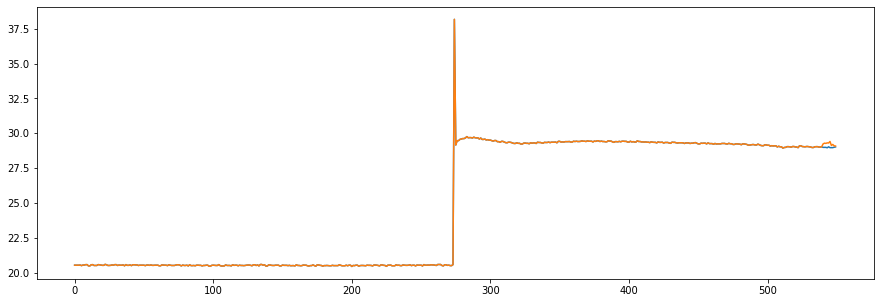

In [118]:
n = 3
plt.plot(test_data[n].numpy())
plt.plot(actual_predictions[n])
# 1, 550

In [123]:
predictions = []
new_model.eval()
with torch.no_grad():
    predictions = [new_model(seq) for (seq, labels) in zip(X_test, y_test)]
pred = [torch.cat((i, j)) for (i, j) in zip(X_test, predictions)]
actual_predictions = np.array([np.array(i) for i in pred])
mape = [np.mean(np.abs(actual_predictions[i] - test[i])/np.abs(test[i])) for i in range(len(test))]
print(sum(mape) / len(mape))
rmse = [np.mean((actual_predictions[i] - test[i])**2)**.5 for i in range(len(test))]
print(sum(rmse) / len(rmse))

0.0097781503902918
47.752345287091714


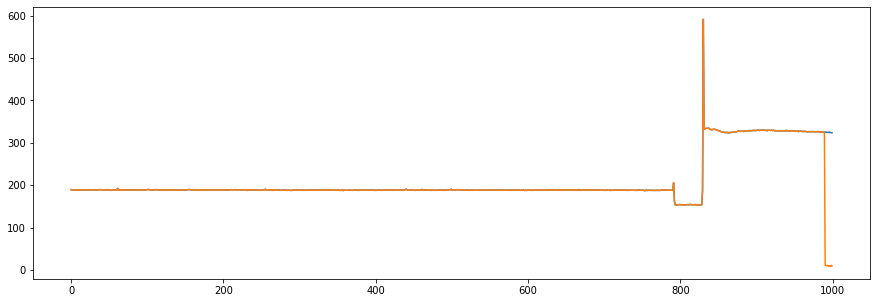

In [127]:
n = 1
plt.plot(test_data[n].numpy())
plt.plot(actual_predictions[n])
# 1.5, 1000